In [1]:
import yfinance as yf
import mplfinance as mpf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Define the ticker symbol for Dow Jones Industrial Average
CODE = '^DJI'
MARKET = "US"

if MARKET == "CN":
    # Get the info of stocks by tushare, Chinese A stock
    import tushare as ts
    ts.set_token('8d8723af16218a29d27bb57f93d0e8a642e481c4d0a0bc9b4da7348d')
    pro = ts.pro_api()

    df = pro.daily(ts_code=CODE, start_date='20210601', end_date='20240930')
    
    df.sort_values(by='trade_date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    df['High'] = df['high']
    df['Low'] = df['low']
    df['Open'] = df['open']
    df['Close'] = df['close']
    df['Volume'] = df['vol']
    
    stock_data = df
    stock_data.set_index(pd.to_datetime(df['trade_date']), inplace=True)
    
else:
    # Create a Ticker object
    stock = yf.Ticker(CODE)
    stock_data = stock.history(period='5y')

from factors_lib import *


def calculate_vwap(high, low, close, volume):
    # Step 1: Calculate the typical price for each period
    typical_price = (high + low + close) / 3
    
    # Step 2: Calculate the total price-volume product
    price_volume_product = typical_price * volume
    
    # Step 3: VWAP is the price-volume product divided by the volume
    vwap = price_volume_product / volume
    
    return vwap


# stock_data = stock_data[:len(stock_data['Close'].values) -7]
target = "Close"
stock_data["ClosePrice"] = stock_data["Close"]
stock_data["HighPrice"] = stock_data["High"]


stock_data['Momentum'] = Momentum(df=stock_data, n_months=3, cal_choose=target)
stock_data["Momentum"] = stock_data["Momentum"].fillna(0)
stock_data["STR"] = Short_Term_Reversion(df=stock_data, cal_choose=target, n_days=5)
stock_data["STR"] = stock_data["STR"].fillna(0)

stock_data["VWAP"] = calculate_vwap(high=stock_data["High"], low=stock_data["Low"], close=stock_data["Close"], volume=stock_data["Volume"])
stock_data["FHW"] = FHW_Approaching(input_df=stock_data) * -1

stock_data["OSS"] = Oversold_Reverse_Score(df=stock_data)
stock_data["CCG"] = CCG_Score(stock_data)
stock_data["ILLIQ"] = ILLIQ_Factor(stock_data, 9)


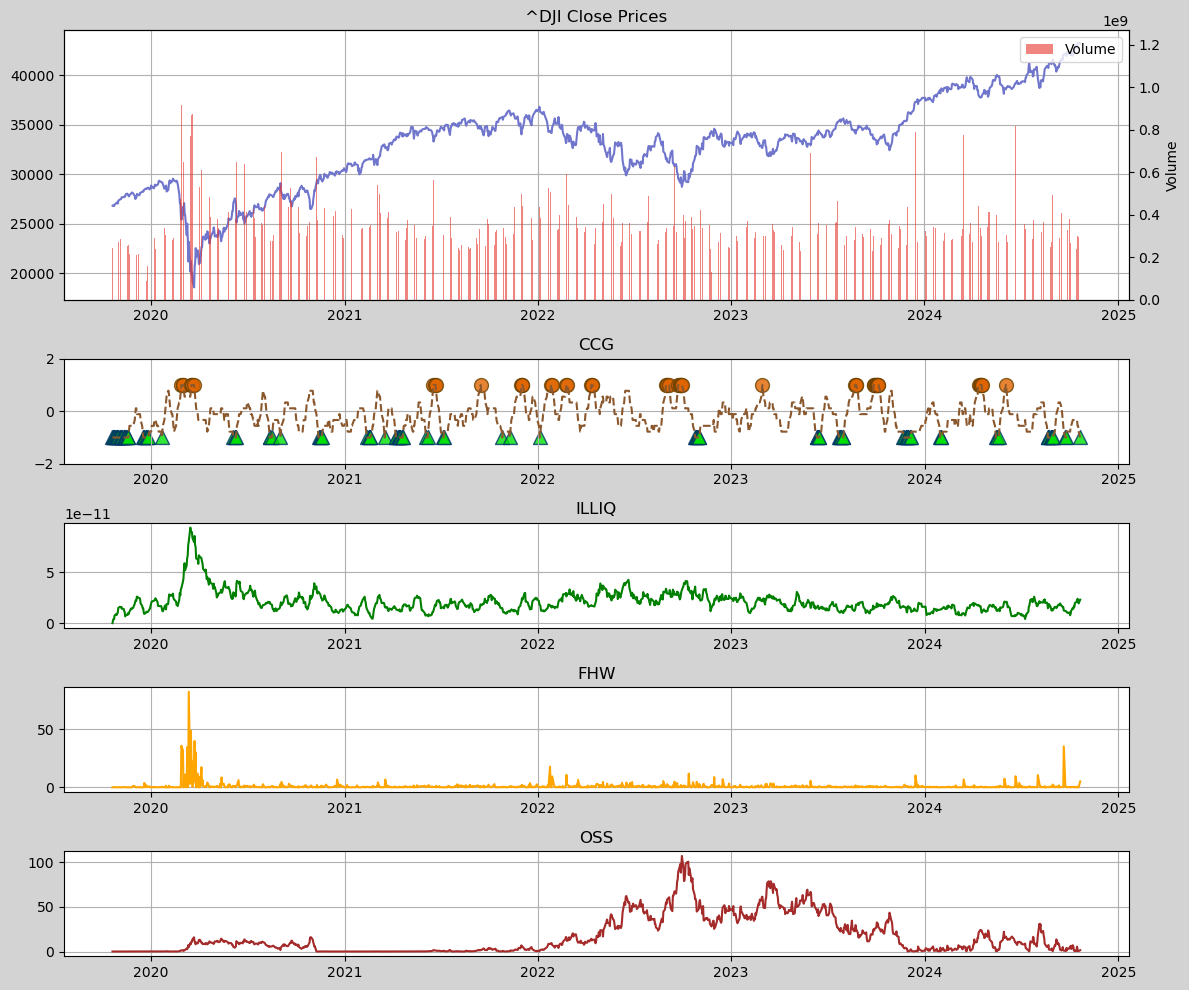

In [2]:
plt.figure(figsize=(12, 10), facecolor='lightgrey')

plt.subplot(6, 1, (1, 2))  # Double size by merging 3 rows
plt.plot(stock_data["Close"], c='#7076cc', lw=1.5)
plt.title(f'{CODE} Close Prices')
plt.grid()

ax2 = plt.gca().twinx()
ax2.bar(stock_data.index, stock_data["Volume"], alpha=0.6, color='#e6332a', width=0.4, label='Volume')
ax2.set_ylabel('Volume')
ax2.legend(loc='upper right')


# CCG Module
plt.subplot(6, 1, 3)
plt.scatter(stock_data.index[stock_data["CCG"] > 0.9],
            stock_data["CCG"].values[stock_data["CCG"] > 0.9],
            s=100, alpha=0.8, c='#E06500', edgecolors='#6B4200')

plt.scatter(stock_data.index[stock_data["CCG"] < -0.9],
            stock_data["CCG"].values[stock_data["CCG"] < -0.9],
            s=100, alpha=0.8, c='#00E005', marker='^', edgecolors='#003366')

plt.plot(stock_data['CCG'], c='#8B582E', ls='--')
plt.ylim([-2, 2])
plt.grid()
plt.title('CCG')


# plt.subplot(6, 1, 4)
# plt.plot(stock_data["STR"], c='g')
# plt.grid()
# plt.title('STR')

# Third subplot
plt.subplot(6, 1, 4)
plt.plot(stock_data["ILLIQ"], c='g')
plt.grid()
plt.title('ILLIQ')

# Fourth subplot
plt.subplot(6, 1, 5)
plt.plot(stock_data["FHW"], c='orange')
plt.grid()
plt.title('FHW')

plt.subplot(6, 1, 6)
plt.plot(stock_data["OSS"], c='brown')
plt.grid()
plt.title('OSS')

plt.tight_layout()
